# Public Housing Resale Price Prediction
This file is dedicated to predicting HDB Resale prices. Our problem statement involves predicting resale prices of HDB resale prices based on features such as housing estate and flat type.

## Data Collection
- The following codes below in this section is dedicated to reading and combining csv files into 1 dataframe.
- We also import all necessary modules in this section as well.

In [2]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import datetime
import glob
import xgboost as xg

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *


In [3]:
import tensorflow as tf
print(tf.__version__)


2.5.0


In [4]:
# Directory Name
file_path = "../dataset/sale-prediction/public-housing/*.csv"

all_public_sales = glob.glob(file_path)
listOfPublic = []
for filename in all_public_sales:
    df = pd.read_csv(filename)
    listOfPublic.append(df)

In [5]:
finaldf = pd.concat(listOfPublic,axis=0, join='inner').sort_index()
finaldf.reset_index(drop=True, inplace=True)
finaldf.head(-6)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0
1,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0
2,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0
3,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0
4,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0
...,...,...,...,...,...,...,...,...,...,...
843913,2012-02,YISHUN,5 ROOM,855,YISHUN RING RD,04 TO 06,127.0,Improved,1988,515000.0
843914,2012-02,YISHUN,5 ROOM,367,YISHUN RING RD,10 TO 12,129.0,Improved,1988,475000.0
843915,2012-02,YISHUN,5 ROOM,366,YISHUN RING RD,07 TO 09,122.0,Improved,1988,448000.0
843916,2012-02,YISHUN,5 ROOM,115B,YISHUN RING RD,16 TO 18,111.0,Improved,2001,528000.0


### Exploratory Data Analysis (EDA)

In [6]:
# Checks how many rows/columns are there
finaldf.shape

(843924, 10)

In [7]:
# Check data types of columns
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843924 entries, 0 to 843923
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                843924 non-null  object 
 1   town                 843924 non-null  object 
 2   flat_type            843924 non-null  object 
 3   block                843924 non-null  object 
 4   street_name          843924 non-null  object 
 5   storey_range         843924 non-null  object 
 6   floor_area_sqm       843924 non-null  float64
 7   flat_model           843924 non-null  object 
 8   lease_commence_date  843924 non-null  int64  
 9   resale_price         843924 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 64.4+ MB


In [8]:
# Find out mean, median, standard deviation, etc
# Data comes from 1990 to 2021
finaldf.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,843924.000000,843924.000000,8.439240e+05
mean,95.618921,1987.350783,2.975429e+05
std,26.018224,9.677939,1.515257e+05
min,28.000000,1966.000000,5.000000e+03
25%,73.000000,1980.000000,1.830000e+05
50%,93.000000,1986.000000,2.788000e+05
75%,114.000000,1995.000000,3.880000e+05
max,307.000000,2019.000000,1.258000e+06


## Data Preparation
- In this section, we will check if our data contains null/empty values and fill in empty data with mean values.
- We will also convert column data to correct data types.

In [9]:
# All data fields are not empty
finaldf.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64

In [10]:
# Convert month column to 'month' type
finaldf['month'] = pd.to_datetime(finaldf['month'],format='%Y-%m', errors='coerce')
# Convert month to ordinal type
finaldf['month'] = finaldf['month'].map(datetime.datetime.toordinal)
finaldf.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,726468,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0
1,735599,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0
2,736330,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0
3,734563,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0
4,730120,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0


In [11]:
# Drop block and street name columns as they are irrelevant
finaldf = finaldf.drop(['block','street_name'], axis=1)
finaldf.head()

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,726468,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,1977,9000.0
1,735599,ANG MO KIO,3 ROOM,07 TO 09,60.0,Improved,1986,255000.0
2,736330,ANG MO KIO,2 ROOM,10 TO 12,44.0,Improved,1979,232000.0
3,734563,ANG MO KIO,2 ROOM,06 TO 10,45.0,Improved,1986,250000.0
4,730120,ANG MO KIO,3 ROOM,07 TO 09,69.0,Improved,1986,147000.0


In [12]:
# Finally checks data type for all columns
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843924 entries, 0 to 843923
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                843924 non-null  int64  
 1   town                 843924 non-null  object 
 2   flat_type            843924 non-null  object 
 3   storey_range         843924 non-null  object 
 4   floor_area_sqm       843924 non-null  float64
 5   flat_model           843924 non-null  object 
 6   lease_commence_date  843924 non-null  int64  
 7   resale_price         843924 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 51.5+ MB


In [13]:
# Converts all string values into uppercase
finaldf['flat_model'] = finaldf['flat_model'].str.upper()
finaldf.head()

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,726468,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,1977,9000.0
1,735599,ANG MO KIO,3 ROOM,07 TO 09,60.0,IMPROVED,1986,255000.0
2,736330,ANG MO KIO,2 ROOM,10 TO 12,44.0,IMPROVED,1979,232000.0
3,734563,ANG MO KIO,2 ROOM,06 TO 10,45.0,IMPROVED,1986,250000.0
4,730120,ANG MO KIO,3 ROOM,07 TO 09,69.0,IMPROVED,1986,147000.0


One hot encode columns for flat_models, town, storey_range, flat_type.

In [14]:
finaldf = pd.get_dummies(finaldf, columns=['town','flat_type', 'storey_range', 'flat_model'])
finaldf.head()

,month,floor_area_sqm,lease_commence_date,resale_price,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,...,flat_model_MULTI GENERATION,flat_model_NEW GENERATION,flat_model_PREMIUM APARTMENT,flat_model_PREMIUM APARTMENT LOFT,flat_model_PREMIUM MAISONETTE,flat_model_SIMPLIFIED,flat_model_STANDARD,flat_model_TERRACE,flat_model_TYPE S1,flat_model_TYPE S2
0,726468,31.0,1977,9000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,735599,60.0,1986,255000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,736330,44.0,1979,232000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,734563,45.0,1986,250000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,730120,69.0,1986,147000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Check columns types again
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843924 entries, 0 to 843923
Data columns (total 84 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   month                              843924 non-null  int64  
 1   floor_area_sqm                     843924 non-null  float64
 2   lease_commence_date                843924 non-null  int64  
 3   resale_price                       843924 non-null  float64
 4   town_ANG MO KIO                    843924 non-null  uint8  
 5   town_BEDOK                         843924 non-null  uint8  
 6   town_BISHAN                        843924 non-null  uint8  
 7   town_BUKIT BATOK                   843924 non-null  uint8  
 8   town_BUKIT MERAH                   843924 non-null  uint8  
 9   town_BUKIT PANJANG                 843924 non-null  uint8  
 10  town_BUKIT TIMAH                   843924 non-null  uint8  
 11  town_CENTRAL AREA                  8439

## Feature Engineering

In [16]:
# Test some code here
# ax = sns.boxplot(x="flat_type", y="resale_price", data=finaldf)
# ax

<AxesSubplot:xlabel='lease_commence_date', ylabel='resale_price'>

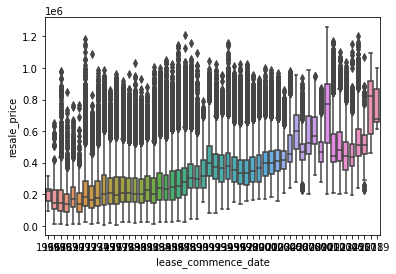

In [17]:
ax = sns.boxplot(x="lease_commence_date", y="resale_price", data=finaldf)
ax

In [18]:
finaldf['price_per_sqm'] = finaldf['resale_price'] / finaldf['floor_area_sqm']
finaldf

,month,floor_area_sqm,lease_commence_date,resale_price,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,...,flat_model_NEW GENERATION,flat_model_PREMIUM APARTMENT,flat_model_PREMIUM APARTMENT LOFT,flat_model_PREMIUM MAISONETTE,flat_model_SIMPLIFIED,flat_model_STANDARD,flat_model_TERRACE,flat_model_TYPE S1,flat_model_TYPE S2,price_per_sqm
0,726468,31.0,1977,9000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,290.322581
1,735599,60.0,1986,255000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4250.000000
2,736330,44.0,1979,232000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5272.727273
3,734563,45.0,1986,250000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5555.555556
4,730120,69.0,1986,147000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2130.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843919,734534,121.0,1985,476888.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3941.223140
843920,734534,122.0,1986,490000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4016.393443
843921,734534,122.0,1988,488000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4000.000000
843922,734534,181.0,1992,705000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3895.027624


Testing some box plot stuff here. Prob gonna add more feature engineering stuff later on

## Training Model - Regression
- Prob will decide which algo will fit the best for this project (might try xgboost & some tensorflow)
- Needs to have validation dataset as well

In [19]:
# X contains features
X = finaldf.drop(['resale_price'], axis=1)

# y contains target to be predicted
y = finaldf['resale_price']

# 80% training data and 10% data for each test and validation data
X_train, X_testTotal, y_train, y_testTotal = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_validation, X_test, y_validation, y_test = train_test_split(X_testTotal, y_testTotal, test_size=0.5, random_state=42)

#### Linear Regression
We will use a simple linear regression alogrithm for this section.

In [20]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [21]:
mse = mean_absolute_error(y_train, reg.predict(X_train))
print("Mean Absolute Error on training data: {:.4f}".format(mse))

mse = mean_absolute_error(y_validation, reg.predict(X_validation))
print("Mean Absolute Error on validation data: {:.4f}".format(mse))
# test = reg.predict(X_validation)
# print(test)
# Result from this cell indicates the difference of actual prices and predicted prices in S$

Mean Absolute Error on training data: 19523.1497
Mean Absolute Error on validation data: 19594.1841


#### XGBoost
We will be using XGBoost for this section.

In [22]:
xgb = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10)

In [27]:
# print(scores)
# xgb.fit(X_train, y_train)
# Predict the model
# pred = xgb.predict(X_test)
# scores = absolute(scores)

param_grid = {'max_depth': range(1,10,2), 'min_child_weight':range(1,6,2)}
gridModel = GridSearchCV(estimator=xgb, param_grid=param_grid)


# More testing is needed here
# Code below is used to cut down on memory needed to copy data
X_train = np.ascontiguousarray(X_train)
y_train = np.ascontiguousarray(y_train)

gridModel.fit(X_train, y_train)
# gridSearchResult.best_params_


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=10, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
       

In [28]:
gridModel.best_score_

0.9957636678207953

In [29]:
gridModel.best_params_

{'max_depth': 9, 'min_child_weight': 3}

In [26]:
scores = cross_val_score(xgb, X_train, y_train, scoring='neg_mean_absolute_error')
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))
  
# RMSE Computation
pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

C:\Users\Hasan\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Hasan\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Hasan\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Hasan\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Hasan\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndar

NameError: name 'pred' is not defined